In [2]:
import pandas as pd
from drevalpy.visualization.critical_difference_plot import CriticalDifferencePlot
from IPython.display import SVG

path_to_source_data_dir = '../results/SourceData'

/Users/judithbernett/miniforge3/envs/drevalpy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ev_res = pd.read_csv(f'{path_to_source_data_dir}/main_results/evaluation_results.csv')
for test_mode in ['LDO', 'LPO', 'LCO', 'LTO']:
    ev_res_subset = ev_res[ev_res["test_mode"] == test_mode]
    eval_results_preds = ev_res_subset[ev_res_subset["rand_setting"] == "predictions"]
    cd_plot = CriticalDifferencePlot(eval_results_preds=eval_results_preds, metric="MSE")
    cd_plot.draw_and_save(
        out_prefix='figures/',
        out_suffix=test_mode,
    )

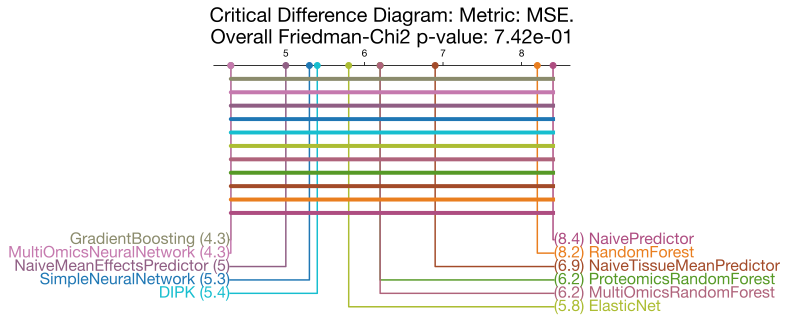

In [4]:
def render_svg(path_to_svg):
    with open(path_to_svg, 'r') as f:
        svg_data = f.read()
    return SVG(data=svg_data)
render_svg('figures/critical_difference_algorithms_LDO.svg')

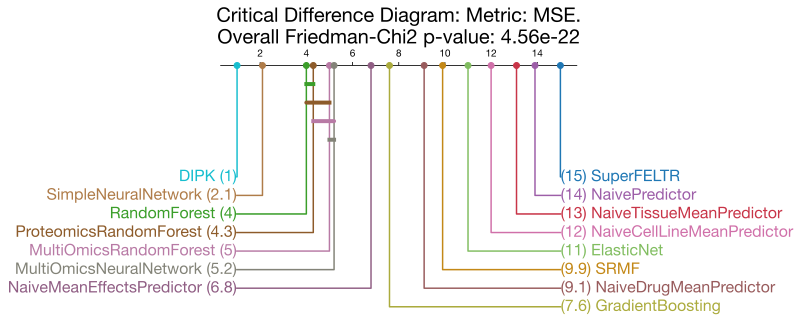

In [5]:
render_svg('figures/critical_difference_algorithms_LPO.svg')

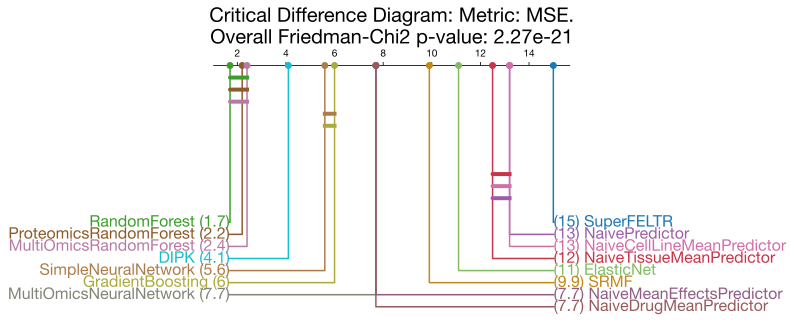

In [6]:
render_svg('figures/critical_difference_algorithms_LCO.svg')

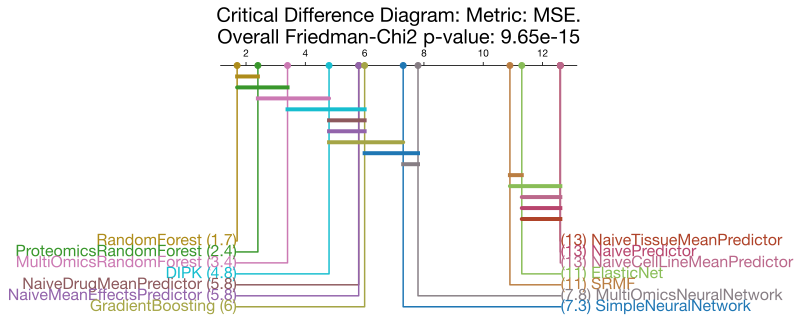

In [7]:
render_svg('figures/critical_difference_algorithms_LTO.svg')

### Extract test statistic with confidence intervals, effect sizes, degrees of freedom and P value

In [8]:
from typing import Union, Optional
import numpy as np
from pandas import DataFrame
import scipy.stats as ss
from scikit_posthocs._posthocs import __convert_to_block_df
from statsmodels.sandbox.stats.multicomp import multipletests
import itertools as it

# modified version that also returns the statistic
def mod_posthoc_conover_friedman(
    a: Union[list, np.ndarray, DataFrame],
    y_col: Optional[str] = None,
    block_col: Optional[str] = None,
    block_id_col: Optional[str] = None,
    group_col: Optional[str] = None,
    melted: bool = False,
    sort: bool = False,
    p_adjust: Optional[str] = None,
):
    def compare_stats(i, j):
        dif = np.abs(R.loc[groups[i]] - R.loc[groups[j]])
        tval = dif / np.sqrt(A) / np.sqrt(B)
        pval = 2.0 * ss.t.sf(np.abs(tval), df=(m * n * k - k - n + 1)).item()
        return pval, tval

    x, _y_col, _group_col, _block_col, _block_id_col = __convert_to_block_df(
        a, y_col, group_col, block_col, block_id_col, melted
    )
    x = x.sort_values(by=[_group_col, _block_col], ascending=True) if sort else x
    x.dropna(inplace=True)

    groups = x[_group_col].unique()
    k = groups.size
    n = x[_block_id_col].unique().size
    print(f"Conover: k={k}, n={n} -> df={n*k-k-n+1}")

    x["mat"] = x.groupby(_block_id_col, observed=True)[_y_col].rank()
    R = x.groupby(_group_col, observed=True)["mat"].sum()
    A1 = (x["mat"] ** 2).sum()
    m = 1
    S2 = m / (m * k - 1.0) * (A1 - m * k * n * ((m * k + 1.0) ** 2.0) / 4.0)
    T2 = 1.0 / S2 * (np.sum((R.to_numpy() - n * m * (m * k + 1.0) / 2.0) ** 2.0))
    A = S2 * (2.0 * n * (m * k - 1.0)) / (m * n * k - k - n + 1.0)
    B = 1.0 - T2 / (n * (m * k - 1.0))

    vs = np.zeros((k, k))
    combs = it.combinations(range(k), 2)

    tri_upper = np.triu_indices(vs.shape[0], 1)
    tri_lower = np.tril_indices(vs.shape[0], -1)
    vs[:, :] = 0
    ts = vs.copy()

    for i, j in combs:
        vs[i, j], ts[i, j] = compare_stats(i, j)

    if p_adjust is not None:
        vs[tri_upper] = multipletests(vs[tri_upper], method=p_adjust)[1]

    vs[tri_lower] = np.transpose(vs)[tri_lower]
    ts[tri_lower] = np.transpose(ts)[tri_lower]
    np.fill_diagonal(vs, 1)
    np.fill_diagonal(ts, 0)
    return DataFrame(vs, index=groups, columns=groups), DataFrame(ts, index=groups, columns=groups)

In [9]:
from scipy import stats
import scikit_posthocs as sp
conover_results = dict()
conover_teststats = dict()
for test_mode in ['LPO', 'LCO', 'LTO', 'LDO']:
    ev_res_subset = ev_res[ev_res["test_mode"] == test_mode]
    eval_results_preds = ev_res_subset[ev_res_subset["rand_setting"] == "predictions"]
    eval_results_preds = eval_results_preds[["algorithm", "CV_split", "MSE"]]
    eval_results_preds.loc[:, "MSE"] = -eval_results_preds.loc[:, "MSE"]
    input_friedman = eval_results_preds.groupby("algorithm")["MSE"].apply(list)
    stat, pval = stats.friedmanchisquare(*input_friedman)
    print(f'Friedman-Chi2 test for {test_mode}, df={len(input_friedman)-1}')
    # Number of blocks (rows)
    n = len(input_friedman.iloc[0])
    # Number of groups (columns)
    k = len(input_friedman)
    print(f'p-value: {pval:.2e}, statistic: {round(stat, 4)}, effect size (Kendalls W): {round(stat/(n*(k-1)), 4)}')
    input_conover_friedman = eval_results_preds.pivot_table(
            index="CV_split", columns="algorithm", values="MSE"
    )
    #conover_results[test_mode] = sp.posthoc_conover_friedman(input_conover_friedman, p_adjust='fdr_bh')
    pval, tval = mod_posthoc_conover_friedman(input_conover_friedman, p_adjust="fdr_bh")
    conover_results[test_mode] = pval
    conover_teststats[test_mode] = tval

Friedman-Chi2 test for LPO, df=14
p-value: 4.56e-22, statistic: 135.93, effect size (Kendalls W): 0.9709
Conover: k=15, n=10 -> df=126
Friedman-Chi2 test for LCO, df=14
p-value: 2.27e-21, statistic: 132.4129, effect size (Kendalls W): 0.9458
Conover: k=15, n=10 -> df=126
Friedman-Chi2 test for LTO, df=13
p-value: 9.65e-15, statistic: 96.0451, effect size (Kendalls W): 0.7388
Conover: k=14, n=10 -> df=117
Friedman-Chi2 test for LDO, df=10
p-value: 7.42e-01, statistic: 6.8182, effect size (Kendalls W): 0.0682
Conover: k=11, n=10 -> df=90


In [10]:
# round to scientific notation
conover_results["LPO"] = conover_results["LPO"].map(lambda x: f"{x:.1e}")
conover_results["LPO"] = conover_results["LPO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_results["LPO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork & SuperFELTR \\
\midrule
DIPK & \added{1.0e+00} & \added{7.3e-54} & \added{2.8e-36} & \added{4.5e-21} & \added{9.1e-20} & \added{3.0e-58} & \added{1.2e-44} & \added{1.9e-31} & \added{1.3e-65} & \added{1.4e-62} & \added{4.0e-15} & \added{3.3e-13} & \added{9.9e-49} & \added{3.5e-03} & \added{3.0e-69} \\
ElasticNet & \added{7.3e-54} & \added{1.0e+00} & \added{8.9e-16} & \added{1.9e-31} & \added{1.2e-32} & \added{7.6e-03} & \added{9.5e-07} & \added{4.5e-21} & \added{1.4e-12} & \added{8.2e-08} & \added{7.1e-37} & \added{1.3e-38} & \added{3.5e-03} & \added{9.9e-49} & \added{9.1e-20} \\
GradientBoosting & \added{2.8e-36} & \added{8.9e-16} & \added{1.0e+00} & \added{1.6e

In [11]:
conover_teststats["LPO"] = conover_teststats["LPO"].round(3)
conover_teststats["LPO"] = conover_teststats["LPO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_teststats["LPO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork & SuperFELTR \\
\midrule
DIPK & \added{0.0} & \added{27.354} & \added{18.053} & \added{11.489} & \added{10.941} & \added{30.089} & \added{22.156} & \added{15.865} & \added{35.286} & \added{33.098} & \added{9.027} & \added{8.206} & \added{24.345} & \added{3.009} & \added{38.295} \\
ElasticNet & \added{27.354} & \added{0.0} & \added{9.3} & \added{15.865} & \added{16.412} & \added{2.735} & \added{5.197} & \added{11.489} & \added{7.933} & \added{5.744} & \added{18.327} & \added{19.148} & \added{3.009} & \added{24.345} & \added{10.941} \\
GradientBoosting & \added{18.053} & \added{9.3} & \added{0.0} & \added{6.565} & \added{7.112} & \added{12.036} & \added{4.103} & \a

In [12]:
# round to scientific notation
conover_results["LCO"] = conover_results["LCO"].map(lambda x: f"{x:.1e}")
conover_results["LCO"] = conover_results["LCO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_results["LCO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork & SuperFELTR \\
\midrule
DIPK & \added{1.0e+00} & \added{6.2e-31} & \added{4.8e-05} & \added{7.4e-13} & \added{2.4e-04} & \added{5.5e-41} & \added{7.4e-13} & \added{7.4e-13} & \added{5.5e-41} & \added{9.1e-38} & \added{4.8e-05} & \added{4.8e-07} & \added{1.3e-24} & \added{1.1e-03} & \added{1.5e-48} \\
ElasticNet & \added{6.2e-31} & \added{1.0e+00} & \added{6.3e-21} & \added{7.7e-12} & \added{3.5e-39} & \added{8.0e-06} & \added{7.7e-12} & \added{7.7e-12} & \added{8.0e-06} & \added{2.3e-03} & \added{4.2e-40} & \added{2.6e-42} & \added{8.9e-03} & \added{4.4e-23} & \added{2.0e-14} \\
GradientBoosting & \added{4.8e-05} & \added{6.3e-21} & \added{1.0e+00} & \added{2.4e

In [13]:
conover_teststats["LCO"] = conover_teststats["LCO"].round(3)
conover_teststats["LCO"] = conover_teststats["LCO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_teststats["LCO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork & SuperFELTR \\
\midrule
DIPK & \added{0.0} & \added{15.702} & \added{4.262} & \added{8.076} & \added{3.813} & \added{20.413} & \added{8.076} & \added{8.076} & \added{20.413} & \added{18.843} & \added{4.262} & \added{5.384} & \added{13.011} & \added{3.365} & \added{24.451} \\
ElasticNet & \added{15.702} & \added{0.0} & \added{11.44} & \added{7.627} & \added{19.516} & \added{4.711} & \added{7.627} & \added{7.627} & \added{4.711} & \added{3.14} & \added{19.964} & \added{21.086} & \added{2.692} & \added{12.338} & \added{8.748} \\
GradientBoosting & \added{4.262} & \added{11.44} & \added{0.0} & \added{3.813} & \added{8.076} & \added{16.151} & \added{3.813} & \added{3

In [14]:
# round to scientific notation
conover_results["LTO"] = conover_results["LTO"].map(lambda x: f"{x:.1e}")
conover_results["LTO"] = conover_results["LTO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_results["LTO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{lllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork \\
\midrule
DIPK & \added{1.0e+00} & \added{4.8e-15} & \added{1.1e-01} & \added{6.5e-05} & \added{6.1e-02} & \added{3.5e-19} & \added{1.8e-01} & \added{1.8e-01} & \added{3.5e-19} & \added{3.5e-19} & \added{1.3e-03} & \added{3.8e-05} & \added{9.5e-14} & \added{8.4e-04} \\
ElasticNet & \added{4.8e-15} & \added{1.0e+00} & \added{2.9e-11} & \added{4.0e-06} & \added{1.9e-19} & \added{7.9e-02} & \added{7.7e-12} & \added{7.7e-12} & \added{7.9e-02} & \added{7.9e-02} & \added{1.0e-22} & \added{8.9e-25} & \added{6.1e-01} & \added{1.9e-07} \\
GradientBoosting & \added{1.1e-01} & \added{2.9e-11} & \added{1.0e+00} & \added{1.6e-02} & \added{5.2e-04} & \added{2.3e-15} & \added{

In [15]:
conover_teststats["LTO"] = conover_teststats["LTO"].round(3)
conover_teststats["LTO"] = conover_teststats["LTO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_teststats["LTO"].to_latex(
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{lllllllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveCellLineMeanPredictor & NaiveDrugMeanPredictor & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SRMF & SimpleNeuralNetwork \\
\midrule
DIPK & \added{0.0} & \added{9.222} & \added{1.703} & \added{4.256} & \added{1.986} & \added{11.067} & \added{1.419} & \added{1.419} & \added{11.067} & \added{11.067} & \added{3.405} & \added{4.398} & \added{8.655} & \added{3.547} \\
ElasticNet & \added{9.222} & \added{0.0} & \added{7.52} & \added{4.966} & \added{11.209} & \added{1.844} & \added{7.804} & \added{7.804} & \added{1.844} & \added{1.844} & \added{12.628} & \added{13.621} & \added{0.568} & \added{5.675} \\
GradientBoosting & \added{1.703} & \added{7.52} & \added{0.0} & \added{2.554} & \added{3.689} & \added{9.364} & \added{0.284} & \added{0.284} & \added{9.364} & \added{9.364} & \added{5.108}

In [16]:
# round all floats to 3 digits
conover_results["LDO"] = conover_results["LDO"].round(3)
conover_results["LDO"] = conover_results["LDO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_results["LDO"].to_latex(
    float_format="%.3f",
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SimpleNeuralNetwork \\
\midrule
DIPK & \added{1.0} & \added{0.857} & \added{0.713} & \added{0.713} & \added{0.762} & \added{0.857} & \added{0.258} & \added{0.577} & \added{0.762} & \added{0.285} & \added{0.98} \\
ElasticNet & \added{0.857} & \added{1.0} & \added{0.577} & \added{0.577} & \added{0.857} & \added{0.762} & \added{0.299} & \added{0.713} & \added{0.857} & \added{0.372} & \added{0.857} \\
GradientBoosting & \added{0.713} & \added{0.577} & \added{1.0} & \added{1.0} & \added{0.441} & \added{0.762} & \added{0.1} & \added{0.299} & \added{0.441} & \added{0.1} & \added{0.738} \\
MultiOmicsNeuralNetwork & \added{0.713} & \added{0.577} & \added{1.0} & \added{1.0} & \added{0.441} & \added{0.762} & \added{0.1} & \added{0.299} & \added{0.441} & \ad

In [17]:
# round all floats to 3 digits
conover_teststats["LDO"] = conover_teststats["LDO"].round(3)
# substitute every entry A in conover_teststats["LDO"] with \added{A}
conover_teststats["LDO"] = conover_teststats["LDO"].astype(str).replace(r"(.+)", r"\\added{\1}", regex=True)
print(conover_teststats["LDO"].to_latex(
    float_format="%.3f",
    na_rep="",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
))

\begin{tabular}{llllllllllll}
\toprule
 & DIPK & ElasticNet & GradientBoosting & MultiOmicsNeuralNetwork & MultiOmicsRandomForest & NaiveMeanEffectsPredictor & NaivePredictor & NaiveTissueMeanPredictor & ProteomicsRandomForest & RandomForest & SimpleNeuralNetwork \\
\midrule
DIPK & \added{0.0} & \added{0.282} & \added{0.774} & \added{0.774} & \added{0.563} & \added{0.282} & \added{2.111} & \added{1.056} & \added{0.563} & \added{1.971} & \added{0.07} \\
ElasticNet & \added{0.282} & \added{0.0} & \added{1.056} & \added{1.056} & \added{0.282} & \added{0.563} & \added{1.83} & \added{0.774} & \added{0.282} & \added{1.689} & \added{0.352} \\
GradientBoosting & \added{0.774} & \added{1.056} & \added{0.0} & \added{0.0} & \added{1.337} & \added{0.493} & \added{2.886} & \added{1.83} & \added{1.337} & \added{2.745} & \added{0.704} \\
MultiOmicsNeuralNetwork & \added{0.774} & \added{1.056} & \added{0.0} & \added{0.0} & \added{1.337} & \added{0.493} & \added{2.886} & \added{1.83} & \added{1.337} & 